# Machine Learning Training Pipeline: Simple Solutions for Datasets Without Missing Values

This notebook demonstrates the machine learning (ML) training pipeline utilizing an open-source library to analyze the complete Post-Traumatic Sepsis dataset(without missing values). The primary focus is on addressing the task of **Rare Event Early Detection**: Sepsis Onset for Critically Ill Trauma Patients.

Given that this problem involves rare event detection, with positive instances representing approximately 4% of the dataset, it presents a significant challenge of class imbalance. To tackle this, we will first apply fundamental techniques such as reweighting, resampling, and augmentation. Subsequently, we will evaluate the limitations of these methods and their impact on model performance.


<!-- 1. **Loading the Dataset**: Begin by loading the dataset into our environment and performing initial exploration.
2. **Training the Model**: Train a model using cross-validation to ensure robust performance evaluation.
3. **Evaluation**: Evaluate the model’s performance using appropriate metrics.
4. **Conclusion**: Summarize findings, discuss implications, highlight limitations, and suggest future work. -->


# 0. Environment Setup

## Mount Google Drive

To access the GitHub project and associated files, you need to mount your Google Drive to Colab. This process allows you to read and write files directly from your Google Drive within the Colab environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set your parameters

Please make sure to update the following parameters to your own:

- **Project ID**: The BigQuery project ID to query the MIMIC-III v1.4 raw data. (If you're not sure what your project ID is, check details in `notebooks/MIMIC_III_Data_Access_Instructions.ipynb`.)
- **BASE_PATH**: The path where the GitHub project will be cloned.

In [2]:
# Remember to update the BigQuery project ID to your own to query raw data
PROJECT_ID = 'sepsis-mimic3'

# Remember to update this variable to your own path
# BASE_PATH is where the GitHub project will be cloned
BASE_PATH = "/content/drive/MyDrive/PTSM_Private_Testing"

## Importing libraries.

In [3]:
%cd {BASE_PATH}/Post_Traumatic_Sepsis_MIMICIII

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# for dataset
from scripts.early_sepsis_onset_detection_setup import dataset_construction
# for model
from tensorflow.keras.utils import to_categorical



# Initialize the ProjectPaths object
from src import path_manager
project_path_obj = path_manager.ProjectPaths(f'{BASE_PATH}/Post_Traumatic_Sepsis_MIMICIII')

/content/drive/MyDrive/PTSM_Private_Testing/Post_Traumatic_Sepsis_MIMICIII


## Load Dataset

In this section, we will load the complete Post-Traumatic Sepsis dataset (without missing values), which is derived from the MIMIC-III v1.4 dataset. For a comprehensive explanation of the dataset construction and additional relevant information, please refer to the `notebooks/Early_Sepsis_Onset_Detection_Setup.ipynb` file.

The dataset table comprises the following columns:

- **Temporal Features**: Multivariate time-series input data with dimensions (# of timestamps, # of features).
- **Label**: Binary value (0 or 1) representing the output label.
- **Dataset**: Indicates whether the instance is part of the training or test set.

Each row in the dataset corresponds to one nighttime instance, and includes patient identifiers (`subject_id`, `hadm_id`) and a timestamp ID (`Date`, `Night`).




In [4]:
# Check if the file exists
file_path = project_path_obj.dataset_wo_nan_path
if os.path.exists(file_path):
    # Load the existing file
    data_wo_nan_df = pd.read_pickle(file_path)
else:
    data_with_nan_df, data_wo_nan_df = dataset_construction(project_path_obj, PROJECT_ID, is_report=True)
data_wo_nan_df.head()

,subject_id,hadm_id,Date,Night,Temporal Features,Label,Dataset
0,43,146828,2186-10-03,3,"[[95.0, 130.0, 71.0, 86.5, 16.0, 37.1111128065...",0,train
1,43,146828,2186-10-04,4,"[[96.0, 117.0, 65.0, 81.0, 17.0, 36.8333350287...",0,train
2,43,146828,2186-10-05,5,"[[96.0, 127.0, 78.0, 92.0, 16.0, 37.6666683620...",0,train
3,43,146828,2186-10-06,6,"[[94.0, 121.0, 71.0, 89.0, 15.0, 36.6111119588...",0,train
5,141,168006,2140-11-07,2,"[[89.0, 163.0, 68.0, 95.0, 18.5, 36.8333350287...",0,train


In [9]:
train_df = data_wo_nan_df[data_wo_nan_df['Dataset'] == 'train']
test_df = data_wo_nan_df[data_wo_nan_df['Dataset'] == 'test']
print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")

Train dataset shape: (8670, 7)
Test dataset shape: (1250, 7)


# Define Model

The classifier model is structured into two main components: an **encoder** and a **classification head**. The encoder utilizes LSTM layers to extract features from multivariate time-series data. These features are then processed by the classification head, which consists of dense layers followed by a softmax layer to generate binary classification outputs. The model is compiled using the Adam optimizer and is evaluated with Precision, Recall, and the Area Under the Precision-Recall Curve (AUC-PR) metrics. This configuration is specifically designed to address imbalanced classification problems, where positive instances are infrequent.

In [17]:
import tensorflow as tf
from tensorflow import keras

def build_model(T, F, loss='binary_crossentropy', learning_rate=1e-5,
                mlp_units=[32], mlp_dropout_rate=0.5):
    inputs = keras.Input(shape=(T, F))

    # Encoder
    enc_output = tf.keras.Sequential([
        keras.layers.LSTM(units=128, return_sequences=True),
        keras.layers.Dropout(rate=0.2),
        keras.layers.LSTM(units=64, return_sequences=False),
    ])(inputs)

    # Classification head
    x = keras.layers.Dropout(mlp_dropout_rate)(enc_output)
    for dim in mlp_units:
        x = keras.layers.Dense(dim, activation="relu", kernel_regularizer='l2')(x)
        x = keras.layers.Dropout(mlp_dropout_rate)(x)

    outputs = keras.layers.Dense(2, activation="softmax")(x)

    # Model creation
    model = keras.Model(inputs, outputs, name='combined_model')

    # Compile model with metrics for imbalanced classification
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt,
                  loss=loss,
                  metrics=[tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall(),
                           tf.keras.metrics.AUC(curve='PR')])

    return model

build_model(train_df.loc[0,'Temporal Features'].shape[0],
            train_df.loc[0,'Temporal Features'].shape[1]).summary()

Model: "combined_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 9, 9)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 64)                  │         120,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,210 (477.38 KB)

 Trainable params: 122,210 (477.38 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
train_df.loc[0,'Temporal Features'].shape

(9, 9)

# Training & Evaluation Process

In this section, we first define several helper functions for model training and evaluation. Subsequently, we conduct five different experiments to address the class imbalance problem, utilizing Stratified 5-Fold Cross-Validation to ensure robust evaluation. The experiments are:

1. **Simple Classification Without Imbalance Techniques**: This serves as the baseline model, where no special techniques are applied to handle the class imbalance.
   
2. **Reweighting**: This approach adjusts the weight of the classes during training to account for the imbalance in the dataset.

3. **Oversampling**: This technique involves increasing the number of positive instances to balance the class distribution.

4. **Augmentation: Timewarp**: This method applies time-series data augmentation using timewarping techniques to enrich the dataset and potentially improve model performance.

5. **Oversampling + Timewarp**: This combined approach uses both oversampling and timewarp augmentation to address class imbalance and enhance the dataset.

Each of these experiments is designed to evaluate different strategies for improving model performance on imbalanced datasets, with Stratified 5-Fold Cross-Validation employed to provide a comprehensive assessment.





## Helper Functions

This section includes functions to facilitate the training and evaluation process of the model:

1. **Split for Train and Validation by Patient Level**: This function partitions the dataset into training and validation sets based on patient identifiers (`subject_id`). This ensures that all data from a single patient is exclusively included in either the training set or the validation set, avoiding data leakage.

2. **Evaluation Function**: This function evaluates the model's performance on a given dataset. It computes metrics such as Precision, Recall, and AUC-PR, providing insights into the model's effectiveness, especially in the context of class imbalance.

3. **Plot Learning Curve**: This function visualizes the model’s learning progress by plotting the training and validation loss curves over epochs. It helps in assessing the model's convergence and diagnosing potential issues such as overfitting or underfitting.

These helper functions are essential for managing data splits, evaluating model performance, and monitoring training progress.



In [11]:
def prepare_train_val_data(train_df, sepsis_patient_df,train_index, val_index, metrics):
    """
    Prepare training and validation data for model training.

    Args:
    - train_df (pd.DataFrame): DataFrame with features and labels.
    - sepsis_patient_df (pd.DataFrame): DataFrame with patient data.
    - train_index (array-like): Indices for training data.
    - val_index (array-like): Indices for validation data.
    - metrics (dict): Dictionary to store metrics.

    Returns:
    - X_train (np.ndarray): Training feature array.
    - X_val (np.ndarray): Validation feature array.
    - y_train (np.ndarray): One-hot encoded training labels.
    - y_val (np.ndarray): One-hot encoded validation labels.
    """
    # Split data based on patient indices
    train = sepsis_patient_df.loc[train_index]
    val = sepsis_patient_df.loc[val_index]

    # Extract features and labels
    X_train = np.stack(train_df.loc[train_df.subject_id.isin(train.subject_id), 'Temporal Features'])
    X_val = np.stack(train_df.loc[train_df.subject_id.isin(val.subject_id), 'Temporal Features'])

    y_train = train_df.loc[train_df.subject_id.isin(train.subject_id), 'Label']
    y_val = train_df.loc[train_df.subject_id.isin(val.subject_id), 'Label']

    # Update metrics
    metrics['num_train_sample'].append(X_train.shape[0])
    metrics['num_train_patient'].append(train.shape[0])
    metrics['num_val_sample'].append(X_val.shape[0])
    metrics['num_val_patient'].append(val.shape[0])

    # Print statistics
    print(f"Train: \t\t{X_train.shape[0]} samples for {train.shape[0]} patients")
    print(f"Validation: \t{X_val.shape[0]} samples for {val.shape[0]} patients")

    # One-hot encode labels
    y_train = to_categorical(y_train, 2)
    y_val = to_categorical(y_val, 2)

    return X_train, X_val, y_train, y_val


from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
def evaluate_model(y_true, y_pred_probs, metrics):
    """
    Evaluates the model's performance using various metrics and updates the metrics dictionary.

    Parameters:
    - y_true: True labels (numpy array or list).
    - y_pred_probs: Predicted probabilities (numpy array).
    - metrics: Dictionary to update with evaluation metrics.

    Returns:
    - None
    """
    # Convert probabilities to binary predictions
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_pr = roc_auc_score(y_true, y_pred_probs[:, 1])
    specificity = recall_score(y_true, y_pred, pos_label=0)

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Append metrics
    metrics['precision'].append(precision)
    metrics['recall'].append(recall)
    metrics['f1_score'].append(f1)
    metrics['auc(PR)'].append(auc_pr)
    metrics['specificity'].append(specificity)
    metrics['tn'].append(tn)
    metrics['fp'].append(fp)
    metrics['fn'].append(fn)
    metrics['tp'].append(tp)

    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_pr': auc_pr,
        'specificity': specificity,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp
    }

# Define the function to plot learning curves
def plot_learning_curves(history):
    """
    Plot the learning curves for training and validation loss/accuracy.

    Parameters:
    - history: The history object returned from model.fit.

    Returns:
    - None
    """
    # Extract metrics from the history object
    epochs = range(1, len(history.history['loss']) + 1)

    # Plot training & validation loss values
    plt.figure(figsize=(4, 3))
    plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

## Simple Classification
This experiment involves training a classification model without applying any techniques to address class imbalance. It serves as a baseline to compare the effectiveness of various imbalance handling methods. The model is trained and evaluated using the original dataset, providing a reference point for assessing the impact of subsequent techniques designed to handle class imbalance.


Fold 1 training...
Train: 		6886 samples for 1075 patients
Validation: 	1784 samples for 269 patients
Epoch 1/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - auc: 0.5811 - loss: 1.1227 - precision: 0.5499 - recall: 0.5499 - val_auc: 0.9526 - val_loss: 0.9687 - val_precision: 0.9585 - val_recall: 0.9585
Epoch 2/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - auc: 0.8552 - loss: 0.9917 - precision: 0.7761 - recall: 0.7761 - val_auc: 0.9529 - val_loss: 0.8504 - val_precision: 0.9591 - val_recall: 0.9591
Epoch 3/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - auc: 0.9293 - loss: 0.8842 - precision: 0.8865 - recall: 0.8865 - val_auc: 0.9485 - val_loss: 0.7564 - val_precision: 0.9591 - val_recall: 0.9591
Epoch 4/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - auc: 0.9501 - loss: 0.8069 - precision: 0.9260 - recall: 0.9260 - val_auc: 0.9484 - val_loss: 0.6850 - val_precision: 0.9591 - val_recall: 0.9591
Epoch 5/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - auc: 0.9430 - loss: 0.7524 - pr

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


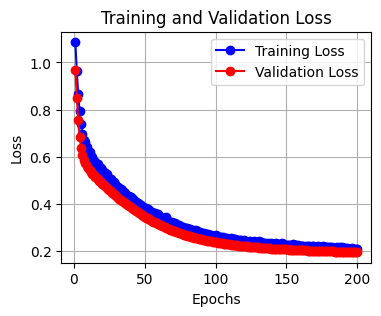


Fold 2 training...
Train: 		6861 samples for 1075 patients
Validation: 	1809 samples for 269 patients
Epoch 1/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - auc_1: 0.4615 - loss: 1.1966 - precision_1: 0.4446 - recall_1: 0.4446 - val_auc_1: 0.9554 - val_loss: 1.0342 - val_precision_1: 0.9585 - val_recall_1: 0.9585
Epoch 2/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - auc_1: 0.8637 - loss: 1.0349 - precision_1: 0.7921 - recall_1: 0.7921 - val_auc_1: 0.9472 - val_loss: 0.8738 - val_precision_1: 0.9596 - val_recall_1: 0.9596
Epoch 3/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - auc_1: 0.9324 - loss: 0.9126 - precision_1: 0.8969 - recall_1: 0.8969 - val_auc_1: 0.9426 - val_loss: 0.7640 - val_precision_1: 0.9596 - val_recall_1: 0.9596
Epoch 4/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - auc_1: 0.9455 - loss: 0.8197 - precision_1: 0.9321 - recall_1: 0.9321 - val_auc_1: 0.9437 - val_loss: 0.6884 - val_precision_1: 0.9596 - val_recall_1: 0.9596
Epoch 5/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


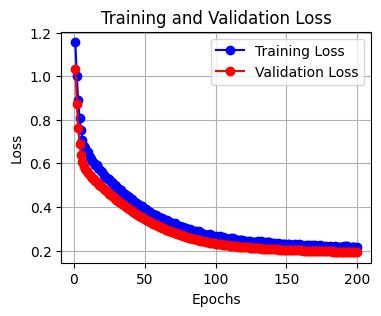


Fold 3 training...
Train: 		6863 samples for 1075 patients
Validation: 	1807 samples for 269 patients
Epoch 1/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - auc_2: 0.3459 - loss: 1.2935 - precision_2: 0.2629 - recall_2: 0.2629 - val_auc_2: 0.9423 - val_loss: 0.9912 - val_precision_2: 0.9292 - val_recall_2: 0.9292
Epoch 2/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - auc_2: 0.6976 - loss: 1.0686 - precision_2: 0.6274 - recall_2: 0.6274 - val_auc_2: 0.9506 - val_loss: 0.8350 - val_precision_2: 0.9590 - val_recall_2: 0.9590
Epoch 3/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - auc_2: 0.8856 - loss: 0.9264 - precision_2: 0.8072 - recall_2: 0.8072 - val_auc_2: 0.9544 - val_loss: 0.7385 - val_precision_2: 0.9596 - val_recall_2: 0.9596
Epoch 4/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - auc_2: 0.9191 - loss: 0.8432 - precision_2: 0.8520 - recall_2: 0.8520 - val_auc_2: 0.9526 - val_loss: 0.6778 - val_precision_2: 0.9596 - val_recall_2: 0.9596
Epoch 5/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 3

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


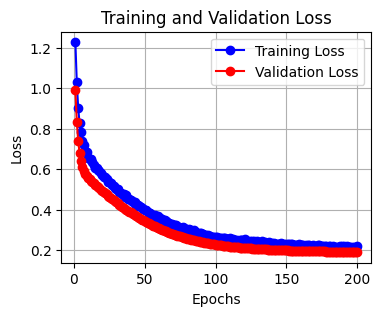


Fold 4 training...
Train: 		7027 samples for 1075 patients
Validation: 	1643 samples for 269 patients
Epoch 1/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - auc_3: 0.4780 - loss: 1.1478 - precision_3: 0.4680 - recall_3: 0.4680 - val_auc_3: 0.9392 - val_loss: 0.9729 - val_precision_3: 0.9544 - val_recall_3: 0.9544
Epoch 2/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - auc_3: 0.8203 - loss: 1.0239 - precision_3: 0.7276 - recall_3: 0.7276 - val_auc_3: 0.9430 - val_loss: 0.8801 - val_precision_3: 0.9544 - val_recall_3: 0.9544
Epoch 3/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - auc_3: 0.9075 - loss: 0.9292 - precision_3: 0.8314 - recall_3: 0.8314 - val_auc_3: 0.9467 - val_loss: 0.7797 - val_precision_3: 0.9544 - val_recall_3: 0.9544
Epoch 4/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - auc_3: 0.9254 - loss: 0.8535 - precision_3: 0.8863 - recall_3: 0.8863 - val_auc_3: 0.9450 - val_loss: 0.6992 - val_precision_3: 0.9544 - val_recall_3: 0.9544
Epoch 5/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


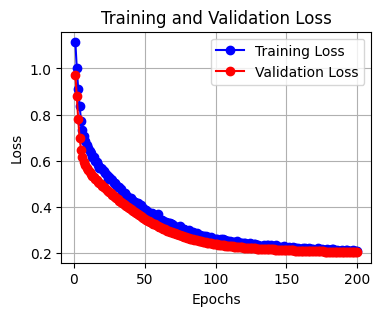


Fold 5 training...
Train: 		7043 samples for 1076 patients
Validation: 	1627 samples for 268 patients
Epoch 1/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - auc_4: 0.6461 - loss: 1.0921 - precision_4: 0.5908 - recall_4: 0.5908 - val_auc_4: 0.9492 - val_loss: 0.9085 - val_precision_4: 0.9545 - val_recall_4: 0.9545
Epoch 2/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - auc_4: 0.9291 - loss: 0.9101 - precision_4: 0.8874 - recall_4: 0.8874 - val_auc_4: 0.9493 - val_loss: 0.7492 - val_precision_4: 0.9551 - val_recall_4: 0.9551
Epoch 3/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - auc_4: 0.9396 - loss: 0.7926 - precision_4: 0.9341 - recall_4: 0.9341 - val_auc_4: 0.9443 - val_loss: 0.6645 - val_precision_4: 0.9551 - val_recall_4: 0.9551
Epoch 4/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - auc_4: 0.9479 - loss: 0.7206 - precision_4: 0.9474 - recall_4: 0.9474 - val_auc_4: 0.9428 - val_loss: 0.6172 - val_precision_4: 0.9551 - val_recall_4: 0.9551
Epoch 5/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


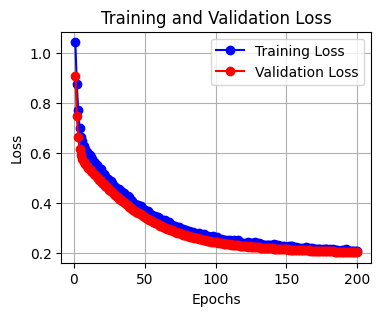


Cross-validation metrics summary:


,num_train_sample,num_train_patient,num_val_sample,num_val_patient,precision,recall,f1_score,auc(PR),specificity,tn,fp,fn,tp
1,6886.0,1075.0,1784.0,269.0,0.0,0.0,0.0,0.537025,1.0,1711.0,0.0,73.0,0.0
2,6861.0,1075.0,1809.0,269.0,0.0,0.0,0.0,0.549318,1.0,1736.0,0.0,73.0,0.0
3,6863.0,1075.0,1807.0,269.0,0.0,0.0,0.0,0.550584,1.0,1734.0,0.0,73.0,0.0
4,7027.0,1075.0,1643.0,269.0,0.0,0.0,0.0,0.591471,1.0,1568.0,0.0,75.0,0.0
5,7043.0,1076.0,1627.0,268.0,0.0,0.0,0.0,0.617787,1.0,1554.0,0.0,73.0,0.0
Average,6936.0,1075.2,1734.0,268.8,0.0,0.0,0.0,0.569237,1.0,1660.6,0.0,73.4,0.0


In [8]:
from sklearn.model_selection import StratifiedKFold


# Initialize metrics dictionary
metrics = {
    'num_train_sample': [], 'num_train_patient': [], 'num_val_sample': [], 'num_val_patient': [],
    'precision': [], 'recall': [], 'f1_score': [], 'auc(PR)': [], 'specificity': [],
    'tn': [], 'fp': [], 'fn': [], 'tp': []
}

# Stratified 5-Fold Cross-Validation based on patient (HADM_ID)
skf = StratifiedKFold(n_splits=5)
sepsis_patient_df = train_df.groupby('subject_id').Label.max().reset_index()

i = 0
for train_index, val_index in skf.split(sepsis_patient_df.subject_id, sepsis_patient_df.Label):
    i += 1
    print(f"\nFold {i} training...")

    # Prepare training and validation data
    X_train, X_val, Y_train, Y_val = prepare_train_val_data(
        train_df, sepsis_patient_df, train_index, val_index, metrics)

    # Initialize model
    model = build_model(X_train.shape[1], X_train.shape[2])

    # Train model
    history = model.fit(X_train, Y_train,
                        validation_data=(X_val, Y_val),
                        epochs=200, batch_size=32, verbose=1)

    # Evaluate model
    y_val_pred_probs = model.predict(X_val)
    y_val_true = np.argmax(Y_val, axis=1)

    # Use the evaluation function
    fold_metrics = evaluate_model(y_val_true, y_val_pred_probs, metrics)

    # print(f"Fold {i} evaluation:")
    # print(f"  Precision: {fold_metrics['precision']:.4f}")
    # print(f"  Recall: {fold_metrics['recall']:.4f}")
    # print(f"  F1 Score: {fold_metrics['f1_score']:.4f}")
    # print(f"  AUC-PR: {fold_metrics['auc_pr']:.4f}")
    # print(f"  Specificity: {fold_metrics['specificity']:.4f}")
    # print(f"  TN: {fold_metrics['tn']}, FP: {fold_metrics['fp']}, FN: {fold_metrics['fn']}, TP: {fold_metrics['tp']}")

    # Plot learning curves
    plot_learning_curves(history)

print("\nCross-validation metrics summary:")
metrics_df = pd.DataFrame(metrics)
metrics_df.index = range(1, len(metrics_df) + 1)
metrics_df.loc['Average', :] = metrics_df.mean(numeric_only=True)
display(metrics_df)

## Reweighting

In this experiment, we address class imbalance by adjusting the weight of the classes during training. This is achieved using class weights, which are computed to give more importance to the minority class.

To compute the class weights, we utilize the `compute_class_weight` function from `sklearn.utils.class_weight`:

```python
from sklearn.utils.class_weight import compute_class_weight
```

This function calculates the weights for each class based on their frequencies in the dataset. The computed weights are then used during model training to mitigate the effects of class imbalance.




Fold 1 training...
Train: 		6886 samples for 1075 patients
Validation: 	1784 samples for 269 patients
Class weights: {0: 0.5222997572815534, 1: 11.710884353741497}
Epoch 1/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - auc_5: 0.5623 - loss: 1.1303 - precision_5: 0.5493 - recall_5: 0.5493 - val_auc_5: 0.7191 - val_loss: 1.1013 - val_precision_5: 0.6648 - val_recall_5: 0.6648
Epoch 2/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - auc_5: 0.5583 - loss: 1.1435 - precision_5: 0.5417 - recall_5: 0.5417 - val_auc_5: 0.7022 - val_loss: 1.0988 - val_precision_5: 0.6530 - val_recall_5: 0.6530
Epoch 3/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc_5: 0.5434 - loss: 1.1499 - precision_5: 0.5331 - recall_5: 0.5331 - val_auc_5: 0.7108 - val_loss: 1.0935 - val_precision_5: 0.6743 - val_recall_5: 0.6743
Epoch 4/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - auc_5: 0.5451 - loss: 1.1842 - precision_5: 0.5377 - recall_5: 0.5377 - val_auc_5: 0.6831 - val_loss: 1.0916 - val_precision_5: 0.6648 - val

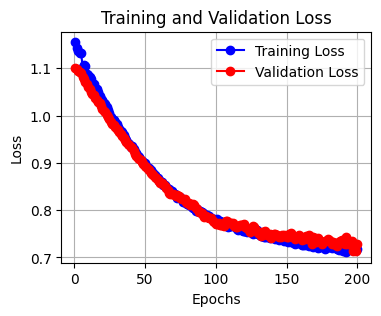


Fold 2 training...
Train: 		6861 samples for 1075 patients
Validation: 	1809 samples for 269 patients
Class weights: {0: 0.522384650525354, 1: 11.668367346938776}
Epoch 1/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - auc_6: 0.9039 - loss: 1.1962 - precision_6: 0.8348 - recall_6: 0.8348 - val_auc_6: 0.9463 - val_loss: 1.0340 - val_precision_6: 0.9596 - val_recall_6: 0.9596
Epoch 2/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - auc_6: 0.8998 - loss: 1.1171 - precision_6: 0.8328 - recall_6: 0.8328 - val_auc_6: 0.9447 - val_loss: 1.0410 - val_precision_6: 0.9596 - val_recall_6: 0.9596
Epoch 3/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - auc_6: 0.8802 - loss: 1.1299 - precision_6: 0.8076 - recall_6: 0.8076 - val_auc_6: 0.9444 - val_loss: 1.0478 - val_precision_6: 0.9596 - val_recall_6: 0.9596
Epoch 4/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - auc_6: 0.8588 - loss: 1.1545 - precision_6: 0.7746 - recall_6: 0.7746 - val_auc_6: 0.9438 - val_loss: 1.0500 - val_precision_6: 0.9596 - val

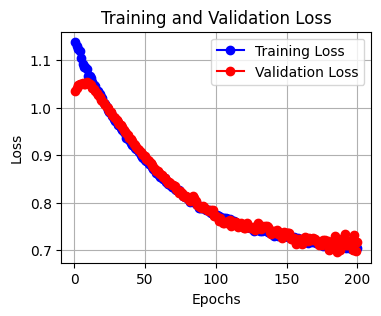


Fold 3 training...
Train: 		6863 samples for 1075 patients
Validation: 	1807 samples for 269 patients
Class weights: {0: 0.5223778352869539, 1: 11.671768707482993}
Epoch 1/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - auc_7: 0.3596 - loss: 1.1506 - precision_7: 0.3199 - recall_7: 0.3199 - val_auc_7: 0.3117 - val_loss: 1.1664 - val_precision_7: 0.0653 - val_recall_7: 0.0653
Epoch 2/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - auc_7: 0.3729 - loss: 1.1239 - precision_7: 0.3527 - recall_7: 0.3527 - val_auc_7: 0.3121 - val_loss: 1.1562 - val_precision_7: 0.0830 - val_recall_7: 0.0830
Epoch 3/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - auc_7: 0.3792 - loss: 1.1767 - precision_7: 0.3422 - recall_7: 0.3422 - val_auc_7: 0.3128 - val_loss: 1.1450 - val_precision_7: 0.0946 - val_recall_7: 0.0946
Epoch 4/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - auc_7: 0.3912 - loss: 1.1058 - precision_7: 0.3674 - recall_7: 0.3674 - val_auc_7: 0.3153 - val_loss: 1.1309 - val_precision_7: 0.1273 - val

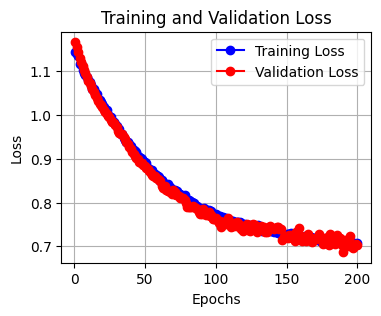


Fold 4 training...
Train: 		7027 samples for 1075 patients
Validation: 	1643 samples for 269 patients
Class weights: {0: 0.5216778025241277, 1: 12.032534246575343}
Epoch 1/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - auc_8: 0.4526 - loss: 1.1434 - precision_8: 0.4478 - recall_8: 0.4478 - val_auc_8: 0.7731 - val_loss: 1.0966 - val_precision_8: 0.6969 - val_recall_8: 0.6969
Epoch 2/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - auc_8: 0.4663 - loss: 1.1258 - precision_8: 0.4581 - recall_8: 0.4581 - val_auc_8: 0.7925 - val_loss: 1.0893 - val_precision_8: 0.7072 - val_recall_8: 0.7072
Epoch 3/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - auc_8: 0.4636 - loss: 1.1053 - precision_8: 0.4606 - recall_8: 0.4606 - val_auc_8: 0.7417 - val_loss: 1.0870 - val_precision_8: 0.6640 - val_recall_8: 0.6640
Epoch 4/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - auc_8: 0.4561 - loss: 1.1015 - precision_8: 0.4496 - recall_8: 0.4496 - val_auc_8: 0.8031 - val_loss: 1.0776 - val_precision_8: 0.7097 - 

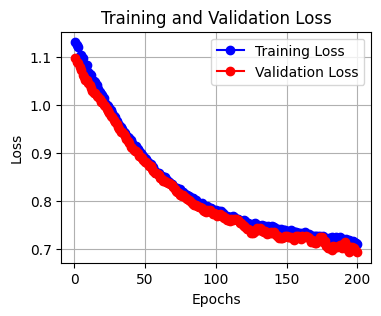


Fold 5 training...
Train: 		7043 samples for 1076 patients
Validation: 	1627 samples for 268 patients
Class weights: {0: 0.521781004593273, 1: 11.977891156462585}
Epoch 1/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - auc_9: 0.3328 - loss: 1.1483 - precision_9: 0.2368 - recall_9: 0.2368 - val_auc_9: 0.3147 - val_loss: 1.1556 - val_precision_9: 0.1162 - val_recall_9: 0.1162
Epoch 2/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - auc_9: 0.3394 - loss: 1.1534 - precision_9: 0.2614 - recall_9: 0.2614 - val_auc_9: 0.3342 - val_loss: 1.1394 - val_precision_9: 0.2581 - val_recall_9: 0.2581
Epoch 3/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - auc_9: 0.3478 - loss: 1.1438 - precision_9: 0.2896 - recall_9: 0.2896 - val_auc_9: 0.3924 - val_loss: 1.1269 - val_precision_9: 0.4124 - val_recall_9: 0.4124
Epoch 4/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - auc_9: 0.3602 - loss: 1.1598 - precision_9: 0.3257 - recall_9: 0.3257 - val_auc_9: 0.4517 - val_loss: 1.1167 - val_precision_9: 0.5040 - val

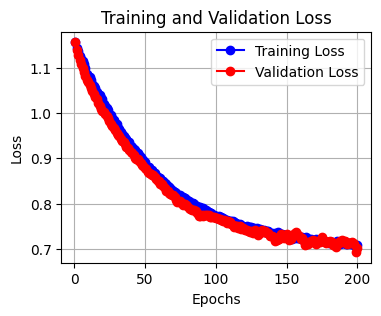


Cross-validation metrics summary:


,num_train_sample,num_train_patient,num_val_sample,num_val_patient,precision,recall,f1_score,auc(PR),specificity,tn,fp,fn,tp
1,6886.0,1075.0,1784.0,269.0,0.046099,0.356164,0.081633,0.545848,0.685564,1173.0,538.0,47.0,26.0
2,6861.0,1075.0,1809.0,269.0,0.040338,0.589041,0.075505,0.529772,0.410714,713.0,1023.0,30.0,43.0
3,6863.0,1075.0,1807.0,269.0,0.049664,0.506849,0.090465,0.563891,0.591696,1026.0,708.0,36.0,37.0
4,7027.0,1075.0,1643.0,269.0,0.048193,0.320000,0.083770,0.550629,0.697704,1094.0,474.0,51.0,24.0
5,7043.0,1076.0,1627.0,268.0,0.056972,0.520548,0.102703,0.594418,0.595238,925.0,629.0,35.0,38.0
Average,6936.0,1075.2,1734.0,268.8,0.048253,0.458521,0.086815,0.556912,0.596183,986.2,674.4,39.8,33.6


In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

# Initialize metrics dictionary
metrics = {
    'num_train_sample': [], 'num_train_patient': [], 'num_val_sample': [], 'num_val_patient': [],
    'precision': [], 'recall': [], 'f1_score': [], 'auc(PR)': [], 'specificity': [],
    'tn': [], 'fp': [], 'fn': [], 'tp': []
}

# Stratified 5-Fold Cross-Validation based on patient (HADM_ID)
skf = StratifiedKFold(n_splits=5)
sepsis_patient_df = train_df.groupby('subject_id').Label.max().reset_index()

i = 0
for train_index, val_index in skf.split(sepsis_patient_df.subject_id, sepsis_patient_df.Label):
    i += 1
    print(f"\nFold {i} training...")

    # Prepare training and validation data
    X_train, X_val, Y_train, Y_val = prepare_train_val_data(
        train_df, sepsis_patient_df, train_index, val_index, metrics)

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(Y_train, axis=1)), y=np.argmax(Y_train, axis=1))
    class_weight_dict = dict(enumerate(class_weights))
    print(f"Class weights: {class_weight_dict}")

    # Initialize model
    model = build_model(X_train.shape[1], X_train.shape[2])

    # Train model with class weights
    history = model.fit(X_train, Y_train,
                        validation_data=(X_val, Y_val),
                        epochs=200, batch_size=32, verbose=1,
                        class_weight=class_weight_dict)

    # Evaluate model
    y_val_pred_probs = model.predict(X_val)
    y_val_true = np.argmax(Y_val, axis=1)

    # Use the evaluation function
    fold_metrics = evaluate_model(y_val_true, y_val_pred_probs, metrics)

    # Plot learning curves
    plot_learning_curves(history)

print("\nCross-validation metrics summary:")
metrics_df = pd.DataFrame(metrics)
metrics_df.index = range(1, len(metrics_df) + 1)
metrics_df.loc['Average', :] = metrics_df.mean(numeric_only=True)
display(metrics_df)

## Augmentation: TimeWarp

In this experiment, we address class imbalance and enhance model performance by applying time-series data augmentation using the **TimeWarp** technique. TimeWarp introduces variability into time-series data by distorting the time axis, which helps the model generalize better and improves its robustness.

To apply TimeWarp augmentation, we use the `TimeWarp` function from the `tsaug` library:

```python
from tsaug import TimeWarp
```

We configure the TimeWarp with the following parameters:

```python
time_warp = TimeWarp(n_speed_change=5, max_speed_ratio=1.5)
```

- **`n_speed_change=5`**: This parameter specifies the number of random speed changes to apply along the time axis. A higher number of speed changes can introduce more variability into the time-series data.

- **`max_speed_ratio=1.5`**: This parameter defines the maximum ratio by which the time axis can be stretched or compressed. A ratio greater than 1.0 allows for stretching the time axis, while a ratio less than 1.0 compresses it. This introduces different temporal distortions, enriching the training data.

**TimeWarp** creates augmented data by applying these distortions, helping to simulate a wider range of temporal patterns and potentially enhancing the model's performance on diverse data.

In [8]:
!pip install tsaug


Fold 1 training...
Train: 		6886 samples for 1075 patients
Validation: 	1784 samples for 269 patients
Epoch 1/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 35s 90ms/step - auc: 0.7267 - loss: 1.0684 - precision: 0.6535 - recall: 0.6535 - val_auc: 0.9472 - val_loss: 0.9402 - val_precision: 0.9585 - val_recall: 0.9585
Epoch 2/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - auc: 0.9157 - loss: 0.9410 - precision: 0.8660 - recall: 0.8660 - val_auc: 0.9439 - val_loss: 0.8120 - val_precision: 0.9591 - val_recall: 0.9591
Epoch 3/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - auc: 0.9447 - loss: 0.8357 - precision: 0.9283 - recall: 0.9283 - val_auc: 0.9485 - val_loss: 0.7160 - val_precision: 0.9591 - val_recall: 0.9591
Epoch 4/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - auc: 0.9419 - loss: 0.7672 - precision: 0.9443 - recall: 0.9443 - val_auc: 0.9469 - val_loss: 0.6538 - val_precision: 0.9591 - val_recall: 0.9591
Epoch 5/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.9529 - loss: 0.7016 - pre

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


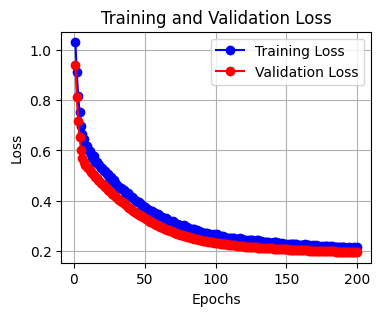


Fold 2 training...
Train: 		6861 samples for 1075 patients
Validation: 	1809 samples for 269 patients
Epoch 1/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - auc_1: 0.8343 - loss: 1.0489 - precision_1: 0.7492 - recall_1: 0.7492 - val_auc_1: 0.9513 - val_loss: 0.9054 - val_precision_1: 0.9596 - val_recall_1: 0.9596
Epoch 2/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - auc_1: 0.9328 - loss: 0.9292 - precision_1: 0.9015 - recall_1: 0.9015 - val_auc_1: 0.9524 - val_loss: 0.7965 - val_precision_1: 0.9596 - val_recall_1: 0.9596
Epoch 3/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - auc_1: 0.9449 - loss: 0.8323 - precision_1: 0.9409 - recall_1: 0.9409 - val_auc_1: 0.9554 - val_loss: 0.7093 - val_precision_1: 0.9596 - val_recall_1: 0.9596
Epoch 4/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - auc_1: 0.9424 - loss: 0.7695 - precision_1: 0.9492 - recall_1: 0.9492 - val_auc_1: 0.9525 - val_loss: 0.6491 - val_precision_1: 0.9596 - val_recall_1: 0.9596
Epoch 5/200
215/215 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


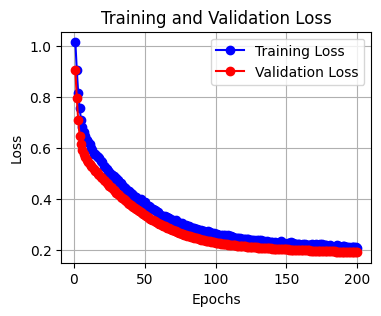


Fold 3 training...
Train: 		6863 samples for 1075 patients
Validation: 	1807 samples for 269 patients
Epoch 1/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - auc_2: 0.7236 - loss: 1.0704 - precision_2: 0.6619 - recall_2: 0.6619 - val_auc_2: 0.9434 - val_loss: 0.9163 - val_precision_2: 0.9590 - val_recall_2: 0.9590
Epoch 2/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - auc_2: 0.9202 - loss: 0.9232 - precision_2: 0.8821 - recall_2: 0.8821 - val_auc_2: 0.9524 - val_loss: 0.7600 - val_precision_2: 0.9596 - val_recall_2: 0.9596
Epoch 3/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - auc_2: 0.9425 - loss: 0.8045 - precision_2: 0.9319 - recall_2: 0.9319 - val_auc_2: 0.9529 - val_loss: 0.6641 - val_precision_2: 0.9596 - val_recall_2: 0.9596
Epoch 4/200
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - auc_2: 0.9443 - loss: 0.7322 - precision_2: 0.9398 - recall_2: 0.9398 - val_auc_2: 0.9505 - val_loss: 0.6148 - val_precision_2: 0.9596 - val_recall_2: 0.9596
Epoch 5/200
215/215 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3 evaluation:
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  AUC-PR: 0.5548
  Specificity: 1.0000
  TN: 1734, FP: 0, FN: 73, TP: 0


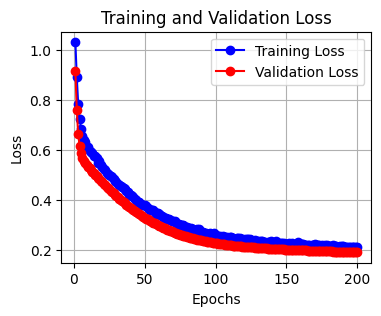


Fold 4 training...
Train: 		7027 samples for 1075 patients
Validation: 	1643 samples for 269 patients
Epoch 1/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - auc_3: 0.8954 - loss: 0.9857 - precision_3: 0.8446 - recall_3: 0.8446 - val_auc_3: 0.9385 - val_loss: 0.8355 - val_precision_3: 0.9544 - val_recall_3: 0.9544
Epoch 2/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - auc_3: 0.9384 - loss: 0.8408 - precision_3: 0.9365 - recall_3: 0.9365 - val_auc_3: 0.9437 - val_loss: 0.7102 - val_precision_3: 0.9544 - val_recall_3: 0.9544
Epoch 3/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - auc_3: 0.9448 - loss: 0.7462 - precision_3: 0.9488 - recall_3: 0.9488 - val_auc_3: 0.9424 - val_loss: 0.6484 - val_precision_3: 0.9544 - val_recall_3: 0.9544
Epoch 4/200
220/220 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - auc_3: 0.9430 - loss: 0.7022 - precision_3: 0.9492 - recall_3: 0.9492 - val_auc_3: 0.9441 - val_loss: 0.6135 - val_precision_3: 0.9544 - val_recall_3: 0.9544
Epoch 5/200
220/220 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 4 evaluation:
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  AUC-PR: 0.5614
  Specificity: 1.0000
  TN: 1568, FP: 0, FN: 75, TP: 0


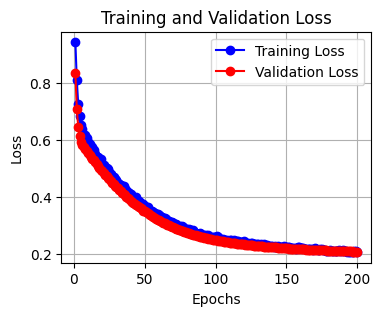


Fold 5 training...
Train: 		7043 samples for 1076 patients
Validation: 	1627 samples for 268 patients
Epoch 1/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - auc_4: 0.4469 - loss: 1.2131 - precision_4: 0.4349 - recall_4: 0.4349 - val_auc_4: 0.9506 - val_loss: 0.9988 - val_precision_4: 0.9551 - val_recall_4: 0.9551
Epoch 2/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - auc_4: 0.8795 - loss: 1.0177 - precision_4: 0.8013 - recall_4: 0.8013 - val_auc_4: 0.9470 - val_loss: 0.8561 - val_precision_4: 0.9551 - val_recall_4: 0.9551
Epoch 3/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - auc_4: 0.9402 - loss: 0.8950 - precision_4: 0.9152 - recall_4: 0.9152 - val_auc_4: 0.9440 - val_loss: 0.7576 - val_precision_4: 0.9551 - val_recall_4: 0.9551
Epoch 4/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - auc_4: 0.9393 - loss: 0.8154 - precision_4: 0.9442 - recall_4: 0.9442 - val_auc_4: 0.9431 - val_loss: 0.6953 - val_precision_4: 0.9551 - val_recall_4: 0.9551
Epoch 5/200
221/221 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


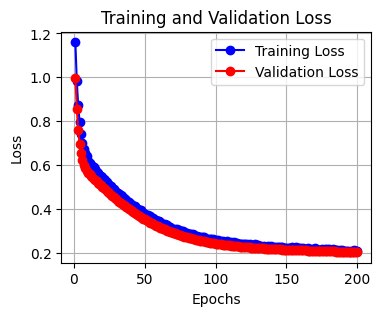


Cross-validation metrics summary:


,num_train_sample,num_train_patient,num_val_sample,num_val_patient,precision,recall,f1_score,auc(PR),specificity,tn,fp,fn,tp
1,6886.0,1075.0,1784.0,269.0,0.0,0.0,0.0,0.521285,1.0,1711.0,0.0,73.0,0.0
2,6861.0,1075.0,1809.0,269.0,0.0,0.0,0.0,0.536417,1.0,1736.0,0.0,73.0,0.0
3,6863.0,1075.0,1807.0,269.0,0.0,0.0,0.0,0.554838,1.0,1734.0,0.0,73.0,0.0
4,7027.0,1075.0,1643.0,269.0,0.0,0.0,0.0,0.561386,1.0,1568.0,0.0,75.0,0.0
5,7043.0,1076.0,1627.0,268.0,0.0,0.0,0.0,0.603304,1.0,1554.0,0.0,73.0,0.0
Average,6936.0,1075.2,1734.0,268.8,0.0,0.0,0.0,0.555446,1.0,1660.6,0.0,73.4,0.0


In [9]:
from sklearn.model_selection import StratifiedKFold
from tsaug import TimeWarp

# Initialize metrics dictionary
metrics = {
    'num_train_sample': [], 'num_train_patient': [], 'num_val_sample': [], 'num_val_patient': [],
    'precision': [], 'recall': [], 'f1_score': [], 'auc(PR)': [], 'specificity': [],
    'tn': [], 'fp': [], 'fn': [], 'tp': []
}

# Stratified 5-Fold Cross-Validation based on patient (HADM_ID)
skf = StratifiedKFold(n_splits=5)
sepsis_patient_df = train_df.groupby('subject_id').Label.max().reset_index()

i = 0
for train_index, val_index in skf.split(sepsis_patient_df.subject_id, sepsis_patient_df.Label):
    i += 1
    print(f"\nFold {i} training...")

    # Prepare training and validation data
    X_train, X_val, Y_train, Y_val = prepare_train_val_data(
        train_df, sepsis_patient_df, train_index, val_index, metrics)

    # Apply augmentation
    # Time Warping
    time_warp = TimeWarp(n_speed_change=5, max_speed_ratio=1.5)
    X_train_augmented = time_warp.augment(X_train)

    # # Mixup
    # mixup = Mixup()
    # X_train_augmented, Y_train_augmented = mixup.augment(X_train, Y_train)

    # Initialize model
    model = build_model(X_train.shape[1], X_train.shape[2])

    # Train model
    history = model.fit(X_train_augmented, Y_train,
                        validation_data=(X_val, Y_val),
                        epochs=200, batch_size=32, verbose=1)

    # Evaluate model
    y_val_pred_probs = model.predict(X_val)
    y_val_true = np.argmax(Y_val, axis=1)

    # Use the evaluation function
    fold_metrics = evaluate_model(y_val_true, y_val_pred_probs, metrics)

    # Print evaluation metrics for the fold
    print(f"Fold {i} evaluation:")
    print(f"  Precision: {fold_metrics['precision']:.4f}")
    print(f"  Recall: {fold_metrics['recall']:.4f}")
    print(f"  F1 Score: {fold_metrics['f1_score']:.4f}")
    print(f"  AUC-PR: {fold_metrics['auc_pr']:.4f}")
    print(f"  Specificity: {fold_metrics['specificity']:.4f}")
    print(f"  TN: {fold_metrics['tn']}, FP: {fold_metrics['fp']}, FN: {fold_metrics['fn']}, TP: {fold_metrics['tp']}")

    # Plot learning curves
    plot_learning_curves(history)

# Convert metrics to DataFrame and display
metrics_df = pd.DataFrame(metrics)
metrics_df.index = range(1, len(metrics_df) + 1)
metrics_df.loc['Average'] = metrics_df.mean(numeric_only=True)
print("\nCross-validation metrics summary:")
display(metrics_df)



## Undersampling + Oversampling

In this experiment, we address class imbalance by combining **undersampling** and **oversampling** techniques to create a balanced dataset. Both classes are adjusted to contain 2,000 instances each.

1. **Undersampling**: We first reduce the number of instances in the majority class to 2,000. This involves removing some instances from the majority class to balance the dataset, which helps mitigate the effects of class imbalance but may result in the loss of potentially useful data.

2. **Oversampling**: We then apply oversampling to the minority class to increase its number of instances to 2,000. This step creates additional samples for the minority class, helping to achieve a balanced dataset.

By combining these techniques, we ensure that both classes have exactly 2,000 instances each. This approach aims to balance the class distribution and improve the model's performance on imbalanced data.


In [21]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Initialize metrics dictionary
metrics = {
    'num_train_sample': [], 'num_train_patient': [], 'num_val_sample': [], 'num_val_patient': [],
    'precision': [], 'recall': [], 'f1_score': [], 'auc(PR)': [], 'specificity': [],
    'tn': [], 'fp': [], 'fn': [], 'tp': []
}

# Stratified 5-Fold Cross-Validation based on patient (HADM_ID)
skf = StratifiedKFold(n_splits=5)
sepsis_patient_df = train_df.groupby('subject_id').Label.max().reset_index()
i=0
for train_index, val_index in skf.split(sepsis_patient_df.subject_id, sepsis_patient_df.Label):
    i += 1
    print(f"\nFold {i} training...")

    # Prepare training and validation data
    X_train, X_val, Y_train, Y_val = prepare_train_val_data(
        train_df, sepsis_patient_df, train_index, val_index, metrics)
    # Y_train_resampled = to_categorical(Y_train_resampled, 2)
    print(f"Before sampling: {Y_train.sum(axis=0)[0]} negative smaple + {Y_train.sum(axis=0)[1]} positive smaple")


    # Apply RandomUnderSampler to handle class imbalance before oversampling
    rus = RandomUnderSampler(sampling_strategy={0: 2000}, random_state=42)
    X_train_resampled, Y_train_resampled = rus.fit_resample(X_train.reshape(X_train.shape[0], -1), Y_train)
    X_train_resampled = X_train_resampled.reshape(-1, X_train.shape[1], X_train.shape[2])

    # Apply RandomOverSampler after downsampling
    ros = RandomOverSampler(random_state=42)
    X_train_resampled, Y_train_resampled = ros.fit_resample(X_train_resampled.reshape(X_train_resampled.shape[0], -1), Y_train_resampled)
    X_train_resampled = X_train_resampled.reshape(-1, X_train.shape[1], X_train.shape[2])
    Y_train_resampled = to_categorical(Y_train_resampled, 2)
    print(f"After sampling: {Y_train_resampled.sum(axis=0)[0]} negative smaple + {Y_train_resampled.sum(axis=0)[1]} positive smaple")
    # break


Y_train_resampled.sum(axis=0)


Fold 1 training...
Train: 		6886 samples for 1075 patients
Validation: 	1784 samples for 269 patients
Before sampling: 6592.0 negative smaple + 294.0 positive smaple
After sampling: 2000.0 negative smaple + 2000.0 positive smaple

Fold 2 training...
Train: 		6861 samples for 1075 patients
Validation: 	1809 samples for 269 patients
Before sampling: 6567.0 negative smaple + 294.0 positive smaple
After sampling: 2000.0 negative smaple + 2000.0 positive smaple

Fold 3 training...
Train: 		6863 samples for 1075 patients
Validation: 	1807 samples for 269 patients
Before sampling: 6569.0 negative smaple + 294.0 positive smaple
After sampling: 2000.0 negative smaple + 2000.0 positive smaple

Fold 4 training...
Train: 		7027 samples for 1075 patients
Validation: 	1643 samples for 269 patients
Before sampling: 6735.0 negative smaple + 292.0 positive smaple
After sampling: 2000.0 negative smaple + 2000.0 positive smaple

Fold 5 training...
Train: 		7043 samples for 1076 patients
Validation: 	162

array([2000., 2000.])


Fold 1 training...
Train: 		6886 samples for 1075 patients
Validation: 	1784 samples for 269 patients
Before sampling: 6592.0 negative samples + 294.0 positive samples
After sampling: 2000.0 negative samples + 2000.0 positive samples
Epoch 1/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - auc: 0.5016 - loss: 1.1564 - precision: 0.4983 - recall: 0.4983 - val_auc: 0.3112 - val_loss: 1.1784 - val_precision: 0.0661 - val_recall: 0.0661
Epoch 2/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - auc: 0.4953 - loss: 1.1454 - precision: 0.4967 - recall: 0.4967 - val_auc: 0.3212 - val_loss: 1.1499 - val_precision: 0.2186 - val_recall: 0.2186
Epoch 3/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - auc: 0.5029 - loss: 1.1337 - precision: 0.4996 - recall: 0.4996 - val_auc: 0.3462 - val_loss: 1.1337 - val_precision: 0.3318 - val_recall: 0.3318
Epoch 4/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - auc: 0.4985 - loss: 1.1279 - precision: 0.5010 - recall: 0.5010 - val_auc: 0.3739 - val_loss: 1.1232 - 

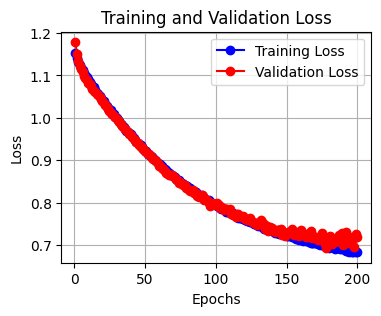


Fold 2 training...
Train: 		6861 samples for 1075 patients
Validation: 	1809 samples for 269 patients
Before sampling: 6567.0 negative samples + 294.0 positive samples
After sampling: 2000.0 negative samples + 2000.0 positive samples
Epoch 1/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - auc_1: 0.4856 - loss: 1.1592 - precision_1: 0.4837 - recall_1: 0.4837 - val_auc_1: 0.3132 - val_loss: 1.1587 - val_precision_1: 0.1211 - val_recall_1: 0.1211
Epoch 2/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - auc_1: 0.4960 - loss: 1.1470 - precision_1: 0.4922 - recall_1: 0.4922 - val_auc_1: 0.3182 - val_loss: 1.1455 - val_precision_1: 0.1647 - val_recall_1: 0.1647
Epoch 3/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - auc_1: 0.4896 - loss: 1.1406 - precision_1: 0.4934 - recall_1: 0.4934 - val_auc_1: 0.3330 - val_loss: 1.1329 - val_precision_1: 0.2504 - val_recall_1: 0.2504
Epoch 4/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - auc_1: 0.4893 - loss: 1.1327 - precision_1: 0.4896 - recall_1: 0.48

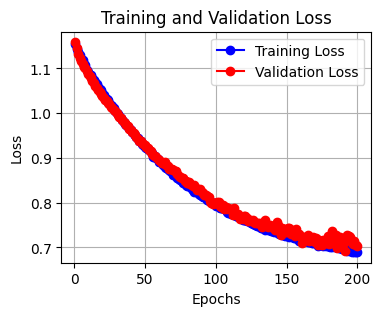


Fold 3 training...
Train: 		6863 samples for 1075 patients
Validation: 	1807 samples for 269 patients
Before sampling: 6569.0 negative samples + 294.0 positive samples
After sampling: 2000.0 negative samples + 2000.0 positive samples
Epoch 1/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - auc_2: 0.5170 - loss: 1.1430 - precision_2: 0.5120 - recall_2: 0.5120 - val_auc_2: 0.3119 - val_loss: 1.1919 - val_precision_2: 0.0742 - val_recall_2: 0.0742
Epoch 2/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - auc_2: 0.5074 - loss: 1.1380 - precision_2: 0.5007 - recall_2: 0.5007 - val_auc_2: 0.3143 - val_loss: 1.1646 - val_precision_2: 0.1372 - val_recall_2: 0.1372
Epoch 3/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - auc_2: 0.5292 - loss: 1.1204 - precision_2: 0.5130 - recall_2: 0.5130 - val_auc_2: 0.3220 - val_loss: 1.1451 - val_precision_2: 0.2037 - val_recall_2: 0.2037
Epoch 4/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - auc_2: 0.5212 - loss: 1.1156 - precision_2: 0.5231 - recall_2: 0.52

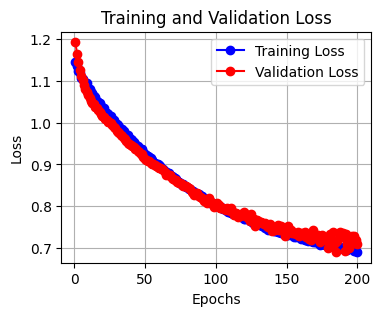


Fold 4 training...
Train: 		7027 samples for 1075 patients
Validation: 	1643 samples for 269 patients
Before sampling: 6735.0 negative samples + 292.0 positive samples
After sampling: 2000.0 negative samples + 2000.0 positive samples
Epoch 1/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - auc_3: 0.5029 - loss: 1.1378 - precision_3: 0.5020 - recall_3: 0.5020 - val_auc_3: 0.8155 - val_loss: 1.0851 - val_precision_3: 0.7736 - val_recall_3: 0.7736
Epoch 2/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - auc_3: 0.5002 - loss: 1.1260 - precision_3: 0.5083 - recall_3: 0.5083 - val_auc_3: 0.6555 - val_loss: 1.0909 - val_precision_3: 0.6099 - val_recall_3: 0.6099
Epoch 3/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - auc_3: 0.5068 - loss: 1.1149 - precision_3: 0.5103 - recall_3: 0.5103 - val_auc_3: 0.4699 - val_loss: 1.0959 - val_precision_3: 0.4632 - val_recall_3: 0.4632
Epoch 4/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - auc_3: 0.5204 - loss: 1.1041 - precision_3: 0.5215 - recall_3: 0.52

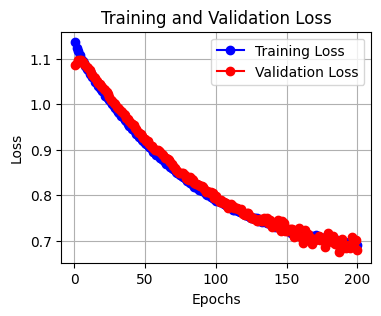


Fold 5 training...
Train: 		7043 samples for 1076 patients
Validation: 	1627 samples for 268 patients
Before sampling: 6749.0 negative samples + 294.0 positive samples
After sampling: 2000.0 negative samples + 2000.0 positive samples
Epoch 1/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - auc_4: 0.4972 - loss: 1.1590 - precision_4: 0.4721 - recall_4: 0.4721 - val_auc_4: 0.3115 - val_loss: 1.1715 - val_precision_4: 0.0559 - val_recall_4: 0.0559
Epoch 2/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - auc_4: 0.5176 - loss: 1.1398 - precision_4: 0.5108 - recall_4: 0.5108 - val_auc_4: 0.3142 - val_loss: 1.1459 - val_precision_4: 0.1364 - val_recall_4: 0.1364
Epoch 3/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - auc_4: 0.5107 - loss: 1.1342 - precision_4: 0.5166 - recall_4: 0.5166 - val_auc_4: 0.3509 - val_loss: 1.1244 - val_precision_4: 0.2766 - val_recall_4: 0.2766
Epoch 4/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - auc_4: 0.4836 - loss: 1.1338 - precision_4: 0.4872 - recall_4: 0.48

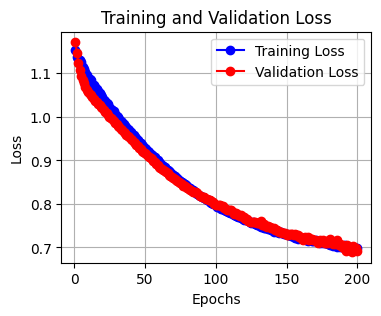


Cross-validation metrics summary:


,num_train_sample,num_train_patient,num_val_sample,num_val_patient,precision,recall,f1_score,auc(PR),specificity,tn,fp,fn,tp
1,6886.0,1075.0,1784.0,269.0,0.044549,0.520548,0.082073,0.518114,0.523670,896.0,815.0,35.0,38.0
2,6861.0,1075.0,1809.0,269.0,0.045249,0.547945,0.083595,0.540386,0.513825,892.0,844.0,33.0,40.0
3,6863.0,1075.0,1807.0,269.0,0.042213,0.397260,0.076316,0.508959,0.620531,1076.0,658.0,44.0,29.0
4,7027.0,1075.0,1643.0,269.0,0.055249,0.400000,0.097087,0.535255,0.672832,1055.0,513.0,45.0,30.0
5,7043.0,1076.0,1627.0,268.0,0.063452,0.342466,0.107066,0.603586,0.762548,1185.0,369.0,48.0,25.0
Average,6936.0,1075.2,1734.0,268.8,0.050142,0.441644,0.089228,0.541260,0.618681,1020.8,639.8,41.0,32.4


In [25]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler

# Initialize metrics dictionary
metrics = {
    'num_train_sample': [], 'num_train_patient': [], 'num_val_sample': [], 'num_val_patient': [],
    'precision': [], 'recall': [], 'f1_score': [], 'auc(PR)': [], 'specificity': [],
    'tn': [], 'fp': [], 'fn': [], 'tp': []
}

# Stratified 5-Fold Cross-Validation based on patient (HADM_ID)
skf = StratifiedKFold(n_splits=5)
sepsis_patient_df = train_df.groupby('subject_id').Label.max().reset_index()

i = 0
for train_index, val_index in skf.split(sepsis_patient_df.subject_id, sepsis_patient_df.Label):
    i += 1
    print(f"\nFold {i} training...")

    # Prepare training and validation data
    X_train, X_val, Y_train, Y_val = prepare_train_val_data(
        train_df, sepsis_patient_df, train_index, val_index, metrics)
    print(f"Before sampling: {Y_train.sum(axis=0)[0]} negative samples + {Y_train.sum(axis=0)[1]} positive samples")

    # Apply RandomUnderSampler to handle class imbalance before oversampling
    rus = RandomUnderSampler(sampling_strategy={0: 2000}, random_state=42)
    X_train_resampled, Y_train_resampled = rus.fit_resample(X_train.reshape(X_train.shape[0], -1), Y_train)
    X_train_resampled = X_train_resampled.reshape(-1, X_train.shape[1], X_train.shape[2])

    # Apply RandomOverSampler after downsampling
    ros = RandomOverSampler(random_state=42)
    X_train_resampled, Y_train_resampled = ros.fit_resample(X_train_resampled.reshape(X_train_resampled.shape[0], -1), Y_train_resampled)
    X_train_resampled = X_train_resampled.reshape(-1, X_train.shape[1], X_train.shape[2])
    Y_train_resampled = to_categorical(Y_train_resampled, 2)
    print(f"After sampling: {Y_train_resampled.sum(axis=0)[0]} negative samples + {Y_train_resampled.sum(axis=0)[1]} positive samples")

    # Initialize model
    model = build_model(X_train.shape[1], X_train.shape[2])

    # Train model
    history = model.fit(X_train_resampled, Y_train_resampled,
                        validation_data=(X_val, Y_val),
                        epochs=200, batch_size=32, verbose=1)

    # Evaluate model
    y_val_pred_probs = model.predict(X_val)
    y_val_true = np.argmax(Y_val, axis=1)

    # Use the evaluation function
    fold_metrics = evaluate_model(y_val_true, y_val_pred_probs, metrics)

    # Plot learning curves
    plot_learning_curves(history)

# Convert metrics to DataFrame and display
metrics_df = pd.DataFrame(metrics)
metrics_df.index = range(1, len(metrics_df) + 1)
metrics_df.loc['Average'] = metrics_df.mean(numeric_only=True)
print("\nCross-validation metrics summary:")
display(metrics_df)


## Synthetic Minority Over-sampling Technique

In this experiment, we address class imbalance by applying the **Synthetic Minority Over-sampling Technique (SMOTE)**. SMOTE increases the number of positive instances in the dataset by generating synthetic samples for the minority class.

To perform SMOTE oversampling, we utilize the `SMOTE` function from the `imblearn` library:

```python
from imblearn.over_sampling import SMOTE
```

SMOTE works by creating synthetic examples through interpolation between existing minority class instances. This approach helps to balance the class distribution and enhances the model's ability to learn from the minority class.

**Comparison with Random Oversampling**:
Unlike the **Random Oversampler** method, which simply duplicates existing minority class instances to balance the dataset, SMOTE generates new, synthetic samples. These synthetic samples are created by interpolating between existing minority class instances, which can lead to a more diverse and richer training dataset. This difference can affect how well the model generalizes to the minority class and can be particularly useful in scenarios where the minority class instances are sparse or clustered.



Fold 1 training...
Train: 		6886 samples for 1075 patients
Validation: 	1784 samples for 269 patients
Epoch 1/200
412/412 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - auc_10: 0.5046 - loss: 1.1392 - precision_10: 0.4986 - recall_10: 0.4986 - val_auc_10: 0.4114 - val_loss: 1.1043 - val_precision_10: 0.4361 - val_recall_10: 0.4361
Epoch 2/200
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - auc_10: 0.5075 - loss: 1.1119 - precision_10: 0.5054 - recall_10: 0.5054 - val_auc_10: 0.6293 - val_loss: 1.0767 - val_precision_10: 0.6256 - val_recall_10: 0.6256
Epoch 3/200
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - auc_10: 0.5205 - loss: 1.0900 - precision_10: 0.5149 - recall_10: 0.5149 - val_auc_10: 0.6984 - val_loss: 1.0590 - val_precision_10: 0.6665 - val_recall_10: 0.6665
Epoch 4/200
412/412 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - auc_10: 0.5210 - loss: 1.0751 - precision_10: 0.5181 - recall_10: 0.5181 - val_auc_10: 0.7290 - val_loss: 1.0432 - val_precision_10: 0.6945 - val_recall_10: 0.6945
Epoch 5/200
412/412 ━

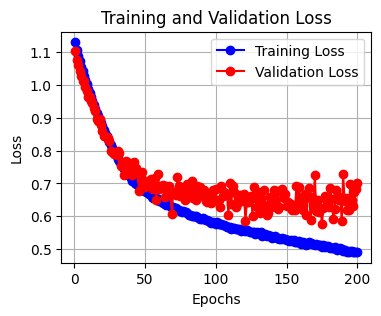


Fold 2 training...
Train: 		6861 samples for 1075 patients
Validation: 	1809 samples for 269 patients
Epoch 1/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - auc_11: 0.5006 - loss: 1.1580 - precision_11: 0.5003 - recall_11: 0.5003 - val_auc_11: 0.9526 - val_loss: 1.0691 - val_precision_11: 0.9403 - val_recall_11: 0.9403
Epoch 2/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - auc_11: 0.5135 - loss: 1.1223 - precision_11: 0.5075 - recall_11: 0.5075 - val_auc_11: 0.9030 - val_loss: 1.0707 - val_precision_11: 0.8242 - val_recall_11: 0.8242
Epoch 3/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc_11: 0.5231 - loss: 1.0996 - precision_11: 0.5169 - recall_11: 0.5169 - val_auc_11: 0.8354 - val_loss: 1.0615 - val_precision_11: 0.7540 - val_recall_11: 0.7540
Epoch 4/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - auc_11: 0.5345 - loss: 1.0807 - precision_11: 0.5279 - recall_11: 0.5279 - val_auc_11: 0.7277 - val_loss: 1.0538 - val_precision_11: 0.6639 - val_recall_11: 0.6639
Epoch 5/200
411/411 

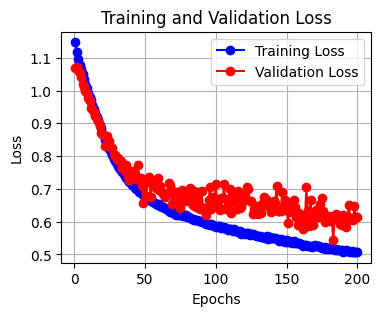


Fold 3 training...
Train: 		6863 samples for 1075 patients
Validation: 	1807 samples for 269 patients
Epoch 1/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - auc_12: 0.4948 - loss: 1.1585 - precision_12: 0.4929 - recall_12: 0.4929 - val_auc_12: 0.9143 - val_loss: 1.0829 - val_precision_12: 0.8827 - val_recall_12: 0.8827
Epoch 2/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc_12: 0.4926 - loss: 1.1241 - precision_12: 0.4912 - recall_12: 0.4912 - val_auc_12: 0.5358 - val_loss: 1.0907 - val_precision_12: 0.4942 - val_recall_12: 0.4942
Epoch 3/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - auc_12: 0.5001 - loss: 1.1018 - precision_12: 0.4950 - recall_12: 0.4950 - val_auc_12: 0.4607 - val_loss: 1.0804 - val_precision_12: 0.4449 - val_recall_12: 0.4449
Epoch 4/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - auc_12: 0.5115 - loss: 1.0822 - precision_12: 0.5082 - recall_12: 0.5082 - val_auc_12: 0.5307 - val_loss: 1.0620 - val_precision_12: 0.5407 - val_recall_12: 0.5407
Epoch 5/200
411/411 

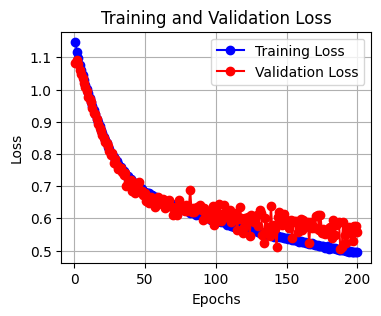


Fold 4 training...
Train: 		7027 samples for 1075 patients
Validation: 	1643 samples for 269 patients
Epoch 1/200
421/421 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - auc_13: 0.5000 - loss: 1.1567 - precision_13: 0.4963 - recall_13: 0.4963 - val_auc_13: 0.9440 - val_loss: 1.0622 - val_precision_13: 0.9404 - val_recall_13: 0.9404
Epoch 2/200
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - auc_13: 0.5188 - loss: 1.1215 - precision_13: 0.5160 - recall_13: 0.5160 - val_auc_13: 0.8909 - val_loss: 1.0690 - val_precision_13: 0.8192 - val_recall_13: 0.8192
Epoch 3/200
421/421 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - auc_13: 0.5136 - loss: 1.1034 - precision_13: 0.5115 - recall_13: 0.5115 - val_auc_13: 0.7672 - val_loss: 1.0672 - val_precision_13: 0.7054 - val_recall_13: 0.7054
Epoch 4/200
421/421 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - auc_13: 0.5229 - loss: 1.0852 - precision_13: 0.5169 - recall_13: 0.5169 - val_auc_13: 0.6202 - val_loss: 1.0619 - val_precision_13: 0.6038 - val_recall_13: 0.6038
Epoch 5/200
421/421

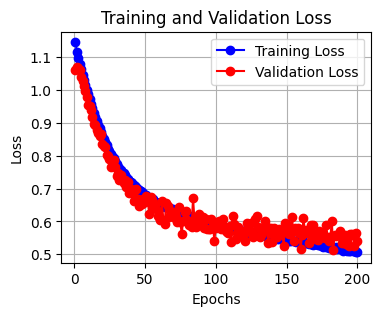


Fold 5 training...
Train: 		7043 samples for 1076 patients
Validation: 	1627 samples for 268 patients
Epoch 1/200
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - auc_14: 0.4970 - loss: 1.1502 - precision_14: 0.5011 - recall_14: 0.5011 - val_auc_14: 0.4123 - val_loss: 1.1215 - val_precision_14: 0.4456 - val_recall_14: 0.4456
Epoch 2/200
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - auc_14: 0.5050 - loss: 1.1233 - precision_14: 0.5041 - recall_14: 0.5041 - val_auc_14: 0.4119 - val_loss: 1.1046 - val_precision_14: 0.4235 - val_recall_14: 0.4235
Epoch 3/200
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - auc_14: 0.5235 - loss: 1.0984 - precision_14: 0.5118 - recall_14: 0.5118 - val_auc_14: 0.4568 - val_loss: 1.0859 - val_precision_14: 0.4444 - val_recall_14: 0.4444
Epoch 4/200
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - auc_14: 0.5296 - loss: 1.0810 - precision_14: 0.5200 - recall_14: 0.5200 - val_auc_14: 0.5656 - val_loss: 1.0634 - val_precision_14: 0.5335 - val_recall_14: 0.5335
Epoch 5/200
422/422

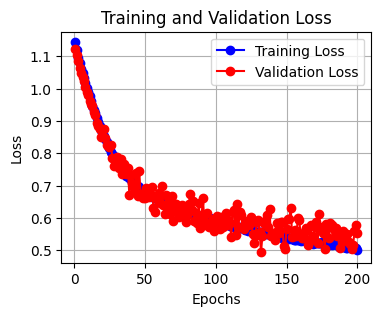


Cross-validation metrics summary:


,num_train_sample,num_train_patient,num_val_sample,num_val_patient,precision,recall,f1_score,auc(PR),specificity,tn,fp,fn,tp
1,6886.0,1075.0,1784.0,269.0,0.039440,0.424658,0.072177,0.479036,0.558738,956.0,755.0,42.0,31.0
2,6861.0,1075.0,1809.0,269.0,0.038748,0.356164,0.069892,0.519877,0.628456,1091.0,645.0,47.0,26.0
3,6863.0,1075.0,1807.0,269.0,0.043783,0.342466,0.077640,0.530581,0.685121,1188.0,546.0,48.0,25.0
4,7027.0,1075.0,1643.0,269.0,0.036000,0.240000,0.062609,0.493810,0.692602,1086.0,482.0,57.0,18.0
5,7043.0,1076.0,1627.0,268.0,0.051724,0.369863,0.090756,0.561503,0.681467,1059.0,495.0,46.0,27.0
Average,6936.0,1075.2,1734.0,268.8,0.041939,0.346630,0.074615,0.516961,0.649277,1076.0,584.6,48.0,25.4


In [11]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE

# Initialize metrics dictionary
metrics = {
    'num_train_sample': [], 'num_train_patient': [], 'num_val_sample': [], 'num_val_patient': [],
    'precision': [], 'recall': [], 'f1_score': [], 'auc(PR)': [], 'specificity': [],
    'tn': [], 'fp': [], 'fn': [], 'tp': []
}

# Stratified 5-Fold Cross-Validation based on patient (HADM_ID)
skf = StratifiedKFold(n_splits=5)
sepsis_patient_df = train_df.groupby('subject_id').Label.max().reset_index()

i = 0
for train_index, val_index in skf.split(sepsis_patient_df.subject_id, sepsis_patient_df.Label):
    i += 1
    print(f"\nFold {i} training...")

    # Prepare training and validation data
    X_train, X_val, Y_train, Y_val = prepare_train_val_data(
        train_df, sepsis_patient_df, train_index, val_index, metrics)

    # Apply SMOTE to handle class imbalance
    smote = SMOTE(random_state=42)
    X_train_resampled, Y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), Y_train)
    X_train_resampled = X_train_resampled.reshape(-1, X_train.shape[1], X_train.shape[2])
    Y_train_resampled = to_categorical(Y_train_resampled, 2)

    # Initialize model
    model = build_model(X_train.shape[1], X_train.shape[2])

    # Train model
    history = model.fit(X_train_resampled, Y_train_resampled,
                        validation_data=(X_val, Y_val),
                        epochs=200, batch_size=32, verbose=1)

    # Evaluate model
    y_val_pred_probs = model.predict(X_val)
    y_val_true = np.argmax(Y_val, axis=1)

    # Use the evaluation function
    fold_metrics = evaluate_model(y_val_true, y_val_pred_probs, metrics)

    # Plot learning curves
    plot_learning_curves(history)

# Convert metrics to DataFrame and display
metrics_df = pd.DataFrame(metrics)
metrics_df.index = range(1, len(metrics_df) + 1)
metrics_df.loc['Average'] = metrics_df.mean(numeric_only=True)
print("\nCross-validation metrics summary:")
display(metrics_df)


## Oversampling (SMOTE) + Augmentation (TimeWarp)

In this experiment, we use a combined approach to address class imbalance and improve model performance:

1. **Oversampling with SMOTE**: We first apply SMOTE to generate synthetic samples for the minority class. This technique creates new examples by interpolating between existing minority class instances, helping to balance the class distribution.

2. **Augmentation with TimeWarp**: We then use TimeWarp to further augment the time-series data. TimeWarp introduces variability by distorting the time axis, such as stretching or compressing it. This adds diversity to the training data, which can enhance the model’s ability to generalize.

By combining SMOTE and TimeWarp, we address class imbalance and enrich the dataset with both synthetic and augmented samples, aiming to improve the model's performance on imbalanced time-series data.



Fold 1 training...
Train: 		6886 samples for 1075 patients
Validation: 	1784 samples for 269 patients
Epoch 1/200
412/412 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - auc_6: 0.5078 - loss: 1.1270 - precision_6: 0.5025 - recall_6: 0.5025 - val_auc_6: 0.4103 - val_loss: 1.1067 - val_precision_6: 0.4198 - val_recall_6: 0.4198
Epoch 2/200
412/412 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - auc_6: 0.5085 - loss: 1.1063 - precision_6: 0.5072 - recall_6: 0.5072 - val_auc_6: 0.4830 - val_loss: 1.0846 - val_precision_6: 0.5348 - val_recall_6: 0.5348
Epoch 3/200
412/412 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - auc_6: 0.5120 - loss: 1.0877 - precision_6: 0.5057 - recall_6: 0.5057 - val_auc_6: 0.5910 - val_loss: 1.0636 - val_precision_6: 0.6390 - val_recall_6: 0.6390
Epoch 4/200
412/412 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - auc_6: 0.5149 - loss: 1.0710 - precision_6: 0.5123 - recall_6: 0.5123 - val_auc_6: 0.5311 - val_loss: 1.0536 - val_precision_6: 0.6003 - val_recall_6: 0.6003
Epoch 5/200
412/412 ━━━━━━━━━━━━━━━━━━

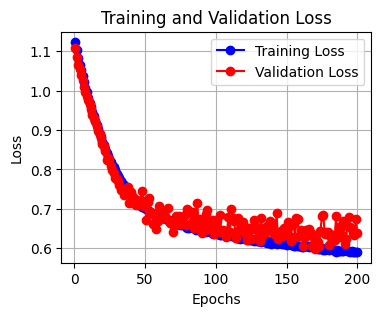


Fold 2 training...
Train: 		6861 samples for 1075 patients
Validation: 	1809 samples for 269 patients
Epoch 1/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - auc_7: 0.5098 - loss: 1.1490 - precision_7: 0.5055 - recall_7: 0.5055 - val_auc_7: 0.4305 - val_loss: 1.1220 - val_precision_7: 0.4245 - val_recall_7: 0.4245
Epoch 2/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - auc_7: 0.5178 - loss: 1.1235 - precision_7: 0.5110 - recall_7: 0.5110 - val_auc_7: 0.3475 - val_loss: 1.1199 - val_precision_7: 0.2863 - val_recall_7: 0.2863
Epoch 3/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - auc_7: 0.5218 - loss: 1.1049 - precision_7: 0.5111 - recall_7: 0.5111 - val_auc_7: 0.3414 - val_loss: 1.1088 - val_precision_7: 0.2609 - val_recall_7: 0.2609
Epoch 4/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - auc_7: 0.5302 - loss: 1.0869 - precision_7: 0.5260 - recall_7: 0.5260 - val_auc_7: 0.3542 - val_loss: 1.0928 - val_precision_7: 0.2875 - val_recall_7: 0.2875
Epoch 5/200
411/411 ━━━━━━━━━━━━━━━━━━

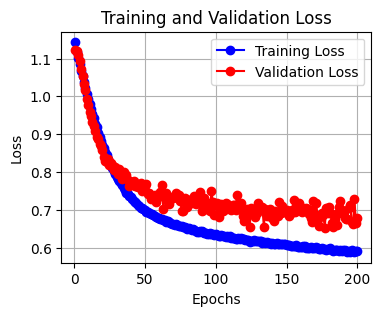


Fold 3 training...
Train: 		6863 samples for 1075 patients
Validation: 	1807 samples for 269 patients
Epoch 1/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - auc_8: 0.5017 - loss: 1.1483 - precision_8: 0.4952 - recall_8: 0.4952 - val_auc_8: 0.7766 - val_loss: 1.1023 - val_precision_8: 0.6193 - val_recall_8: 0.6193
Epoch 2/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - auc_8: 0.5052 - loss: 1.1231 - precision_8: 0.5094 - recall_8: 0.5094 - val_auc_8: 0.7543 - val_loss: 1.0898 - val_precision_8: 0.6071 - val_recall_8: 0.6071
Epoch 3/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - auc_8: 0.5066 - loss: 1.1039 - precision_8: 0.5073 - recall_8: 0.5073 - val_auc_8: 0.7822 - val_loss: 1.0741 - val_precision_8: 0.6475 - val_recall_8: 0.6475
Epoch 4/200
411/411 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - auc_8: 0.5011 - loss: 1.0881 - precision_8: 0.5009 - recall_8: 0.5009 - val_auc_8: 0.7078 - val_loss: 1.0633 - val_precision_8: 0.5805 - val_recall_8: 0.5805
Epoch 5/200
411/411 ━━━━━━━━━━━━━━━━━━

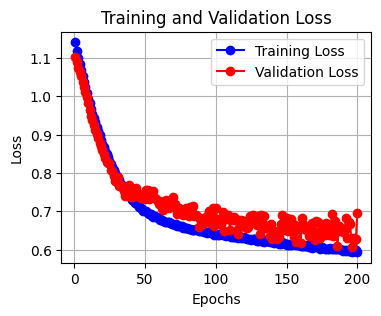


Fold 4 training...
Train: 		7027 samples for 1075 patients
Validation: 	1643 samples for 269 patients
Epoch 1/200
421/421 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - auc_9: 0.5141 - loss: 1.1388 - precision_9: 0.5080 - recall_9: 0.5080 - val_auc_9: 0.3678 - val_loss: 1.1188 - val_precision_9: 0.3774 - val_recall_9: 0.3774
Epoch 2/200
421/421 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - auc_9: 0.5099 - loss: 1.1108 - precision_9: 0.5089 - recall_9: 0.5089 - val_auc_9: 0.5273 - val_loss: 1.0868 - val_precision_9: 0.6269 - val_recall_9: 0.6269
Epoch 3/200
421/421 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - auc_9: 0.5068 - loss: 1.0915 - precision_9: 0.5109 - recall_9: 0.5109 - val_auc_9: 0.6694 - val_loss: 1.0654 - val_precision_9: 0.6932 - val_recall_9: 0.6932
Epoch 4/200
421/421 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - auc_9: 0.4996 - loss: 1.0753 - precision_9: 0.5061 - recall_9: 0.5061 - val_auc_9: 0.7516 - val_loss: 1.0486 - val_precision_9: 0.7200 - val_recall_9: 0.7200
Epoch 5/200
421/421 ━━━━━━━━━━━━━━━━━

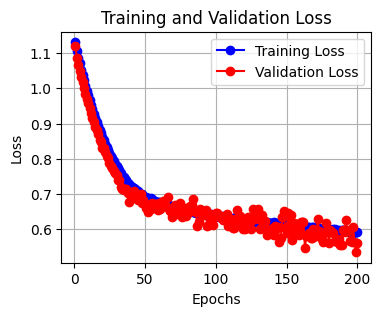


Fold 5 training...
Train: 		7043 samples for 1076 patients
Validation: 	1627 samples for 268 patients
Epoch 1/200
422/422 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - auc_10: 0.4871 - loss: 1.1264 - precision_10: 0.4886 - recall_10: 0.4886 - val_auc_10: 0.7496 - val_loss: 1.0777 - val_precision_10: 0.7044 - val_recall_10: 0.7044
Epoch 2/200
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - auc_10: 0.4995 - loss: 1.1022 - precision_10: 0.5032 - recall_10: 0.5032 - val_auc_10: 0.6078 - val_loss: 1.0725 - val_precision_10: 0.6091 - val_recall_10: 0.6091
Epoch 3/200
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - auc_10: 0.5209 - loss: 1.0808 - precision_10: 0.5233 - recall_10: 0.5233 - val_auc_10: 0.6744 - val_loss: 1.0532 - val_precision_10: 0.6589 - val_recall_10: 0.6589
Epoch 4/200
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - auc_10: 0.5293 - loss: 1.0638 - precision_10: 0.5210 - recall_10: 0.5210 - val_auc_10: 0.6227 - val_loss: 1.0420 - val_precision_10: 0.6325 - val_recall_10: 0.6325
Epoch 5/200
4

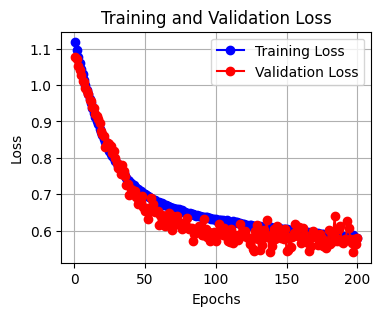


Cross-validation metrics summary:


,num_train_sample,num_train_patient,num_val_sample,num_val_patient,precision,recall,f1_score,auc(PR),specificity,tn,fp,fn,tp
1,6886.0,1075.0,1784.0,269.0,0.039456,0.397260,0.071782,0.500765,0.587376,1005.0,706.0,44.0,29.0
2,6861.0,1075.0,1809.0,269.0,0.042576,0.534247,0.078868,0.522994,0.494816,859.0,877.0,34.0,39.0
3,6863.0,1075.0,1807.0,269.0,0.043067,0.561644,0.080000,0.527990,0.474625,823.0,911.0,32.0,41.0
4,7027.0,1075.0,1643.0,269.0,0.042885,0.293333,0.074830,0.516956,0.686862,1077.0,491.0,53.0,22.0
5,7043.0,1076.0,1627.0,268.0,0.054795,0.438356,0.097412,0.545318,0.644788,1002.0,552.0,41.0,32.0
Average,6936.0,1075.2,1734.0,268.8,0.044556,0.444968,0.080578,0.522805,0.577693,953.2,707.4,40.8,32.6


In [14]:
from sklearn.model_selection import StratifiedKFold
from tsaug import TimeWarp
from imblearn.over_sampling import SMOTE


# Initialize metrics dictionary
metrics = {
    'num_train_sample': [], 'num_train_patient': [], 'num_val_sample': [], 'num_val_patient': [],
    'precision': [], 'recall': [], 'f1_score': [], 'auc(PR)': [], 'specificity': [],
    'tn': [], 'fp': [], 'fn': [], 'tp': []
}

# Stratified 5-Fold Cross-Validation based on patient (HADM_ID)
skf = StratifiedKFold(n_splits=5)
sepsis_patient_df = train_df.groupby('subject_id').Label.max().reset_index()

i = 0
for train_index, val_index in skf.split(sepsis_patient_df.subject_id, sepsis_patient_df.Label):
    i += 1
    print(f"\nFold {i} training...")

    # Prepare training and validation data
    X_train, X_val, Y_train, Y_val = prepare_train_val_data(
        train_df, sepsis_patient_df, train_index, val_index, metrics)

    # Apply SMOTE to oversample the minority class
    smote = SMOTE()
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Reshape for SMOTE
    X_train_resampled, Y_train_resampled = smote.fit_resample(X_train_reshaped, np.argmax(Y_train, axis=1))
    X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], X_train.shape[1], X_train.shape[2])  # Reshape back
    Y_train_resampled = to_categorical(Y_train_resampled, 2)


    # Apply Time Warping augmentation
    time_warp = TimeWarp(n_speed_change=5, max_speed_ratio=1.5)
    X_train_augmented = np.array([time_warp.augment(x) for x in X_train_resampled])

    # Initialize model
    model = build_model(X_train.shape[1], X_train.shape[2])

    # Train model
    history = model.fit(X_train_augmented, Y_train_resampled,
                        validation_data=(X_val, Y_val),
                        epochs=200, batch_size=32, verbose=1)

    # Evaluate model
    y_val_pred_probs = model.predict(X_val)
    y_val_true = np.argmax(Y_val, axis=1)

    # Use the evaluation function
    fold_metrics = evaluate_model(y_val_true, y_val_pred_probs, metrics)

    # Plot learning curves
    plot_learning_curves(history)

# Convert metrics to DataFrame and display
metrics_df = pd.DataFrame(metrics)
metrics_df.index = range(1, len(metrics_df) + 1)
metrics_df.loc['Average'] = metrics_df.mean(numeric_only=True)
print("\nCross-validation metrics summary:")
display(metrics_df)
